In [1]:
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [3]:
# Handling images
from PIL import Image
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision.datasets import ImageFolder
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import datasets, models, transforms, utils
from torchvision.transforms import v2

In [4]:
import cv2
import os
from glob import glob
from tqdm import tqdm
import shutil
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , accuracy_score, classification_report

import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp

In [5]:
labels_df = pd.read_csv("C:\\Users\\ziatd\\Desktop\\people-clothing-segmentation\\labels (1).csv")
img_paths = sorted(glob('C:\\Users\\ziatd\\Desktop\\people-clothing-segmentation\\jpeg_images\\IMAGES\\*.jpeg'))
mask_paths = sorted(glob('C:\\Users\\ziatd\\Desktop\\people-clothing-segmentation\\jpeg_masks\\MASKS\\*.jpeg'))
my_paths = sorted(glob('C:\\Users\\ziatd\\Desktop\\people-clothing-segmentation\\*.jpg'))
df = pd.DataFrame({"img":img_paths,"mask":mask_paths})
my_df = pd.DataFrame({"img":my_paths})

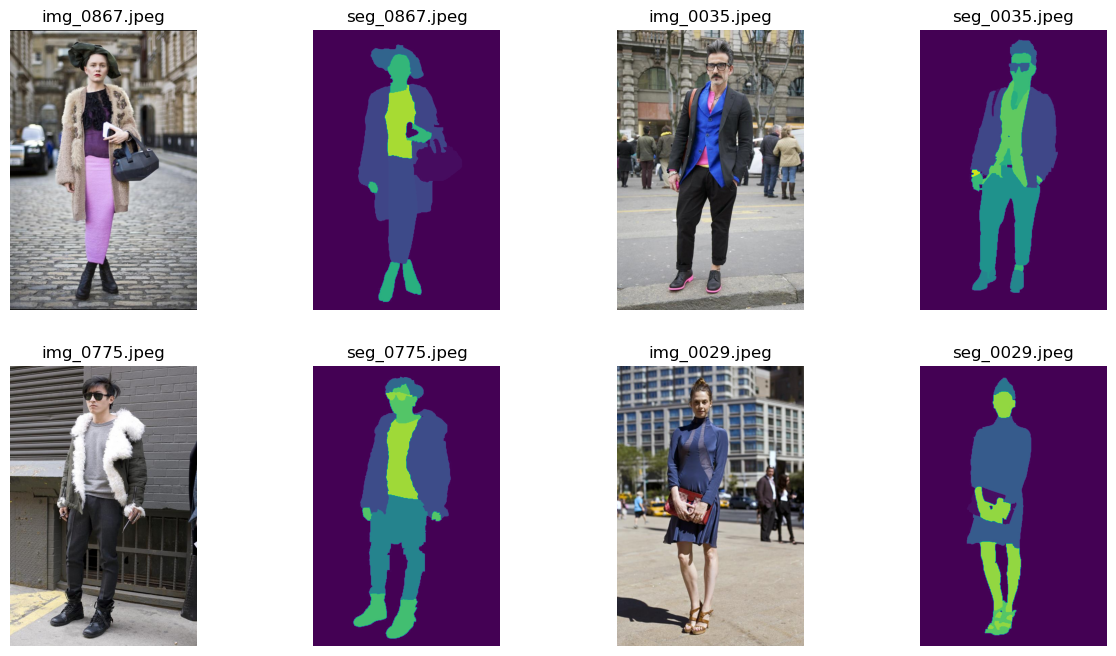

In [6]:
#Изображения с масками
show_imgs = 4
idx = np.random.choice(len(df), show_imgs, replace=False)
fig, axes = plt.subplots(show_imgs*2//4, 4, figsize=(15, 8))
axes = axes.flatten()
for i, ax in enumerate(axes):
    new_i = i//2
    if i % 2 ==0 :
        full_path = df.loc[idx[new_i]]['img']
    else:
        full_path = df.loc[idx[new_i]]['mask']
    ax.imshow(plt.imread(full_path))
    basename = os.path.basename(full_path) 
    ax.set_title(basename)
    ax.set_axis_off()

In [7]:
train_transforms = A.Compose([
    A.Resize(576, 576),
    A.RandomCrop(height=512, width=512, always_apply=True),
    A.HorizontalFlip(p=0.5),
    # A.VerticalFlip(p=0.5),
    # A.RandomRotate90(p=0.5),
    # A.Transpose(p=0.2),
    A.ShiftScaleRotate(shift_limit=0.01, scale_limit=(-0.04,0.04), rotate_limit=(-5,5), p=0.5),
])

test_transforms = A.Compose([
    A.Resize(512, 512),
])


class MyDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, transforms_=None):
        self.df = dataframe
        # Будем использовать преобразования для дополнения данных и преобразования изображений PIL в тензоры.
        self.transforms_ = transforms_
        self.pre_normalize = v2.Compose([
            v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        self.resize = [512, 512]
        self.class_size = 59
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img = cv2.cvtColor(cv2.imread(self.df.iloc[index]['img']), cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.df.iloc[index]['mask'],cv2.IMREAD_GRAYSCALE)
        mask[mask > self.class_size-1] = 0
        aug = self.transforms_(image=img, mask=mask)            
        img, mask = aug['image'], aug['mask']
        img = img/255
        img = self.pre_normalize(img)
        img = torch.tensor(img, dtype=torch.float).permute(2, 0, 1)
        target = torch.tensor(mask, dtype=torch.long)
        sample = {'x': img, 'y': target}
        return sample

In [8]:
device = torch.device("cuda" if torch.cuda.is_available else "cpu")
train_df, val_df = train_test_split(df, test_size=0.2)
train_dataset = MyDataset(train_df, train_transforms)
val_dataset = MyDataset(val_df, test_transforms)

BATCH_SIZE = 5
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

In [9]:
class_size = 59
model = smp.Unet(
    encoder_name="efficientnet-b4",        # энкодер, mobilenet_v2 или efficientnet-b7
    encoder_weights="imagenet",     # используем `imagenet` предобученные веса для инициализации энкодера
    in_channels=3,                  # входные каналы (1 for gray-scale images, 3 for RGB)
    classes=class_size,                      # выходной канал (кол-во классов)
)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model(torch.randn((1,3,512,512))).shape

torch.Size([1, 59, 512, 512])

In [10]:
def train(dataloader, model, loss_fn, optimizer, lr_scheduler):
    size = len(dataloader.dataset) # кол-во сэмлов
    num_batches = len(dataloader)
    # обучение
    model.train() 
    epoch_loss = 0
    epoch_iou_score = 0
    for batch_i, batch in enumerate(dataloader):
        x, y = batch['x'].to(device), batch['y'].to(device) # GPU
        optimizer.zero_grad()
        pred = model(x)
        loss = loss_fn(pred, y)

        loss.backward()
        optimizer.step() # обновление параметров

        epoch_loss += loss.item()
        y = y.round().long()
        pred = torch.argmax(pred,dim=1)
        tp, fp, fn, tn = smp.metrics.get_stats(pred, y, mode='multiclass', num_classes=class_size)
        iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro").item()
        epoch_iou_score += iou_score
        lr_scheduler.step()
    
    # средние потери, accuracy
    return epoch_loss/num_batches, epoch_iou_score/num_batches



def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    # тест
    model.eval() 
    epoch_loss = 0
    epoch_iou_score = 0
    with torch.no_grad():
        for batch_i, batch in enumerate(dataloader):
            x, y = batch['x'].to(device), batch['y'].to(device) # move data to GPU
            # Потери предсказания
            pred = model(x)
            loss = loss_fn(pred, y)

            epoch_loss += loss.item()
            
            y = y.round().long()
            pred = torch.argmax(pred,dim=1)
            tp, fp, fn, tn = smp.metrics.get_stats(pred, y, mode='multiclass', num_classes=class_size)
            iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro").item()
            epoch_iou_score += iou_score
    return epoch_loss/num_batches, epoch_iou_score/num_batches

In [11]:
EPOCHS = 28
logs = {
    'train_loss': [], 'val_loss': [],
    'train_iou_score': [], 'val_iou_score': [],
}

if os.path.exists('checkpoints') == False:
    os.mkdir("checkpoints")

loss_fn = smp.losses.DiceLoss(mode='multiclass')


learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size = 2000, gamma=0.1)

# Ранняя остановка
patience = 5
counter = 0
best_loss = np.inf


model.to(device)
for epoch in tqdm(range(EPOCHS)):
    train_loss, train_iou_score = train(train_loader, model, loss_fn, optimizer, step_lr_scheduler)
    val_loss, val_iou_score = test(val_loader, model, loss_fn)
    logs['train_loss'].append(train_loss)
    logs['val_loss'].append(val_loss)
    logs['train_iou_score'].append(train_iou_score)
    logs['val_iou_score'].append(val_iou_score)

    print(f'EPOCH: {str(epoch+1).zfill(3)} \
    train_loss: {train_loss:.4f}, val_loss: {val_loss:.4f} \
    train_iou_score: {train_iou_score:.3f}, val_iou_score: {val_iou_score:.3f} \
    lr: {optimizer.param_groups[0]["lr"]}')

    torch.save(model.state_dict(), "checkpoints/last.pth")
    # проверка улучшений
    if val_loss < best_loss:
        counter = 0
        best_loss = val_loss
        torch.save(model.state_dict(), "checkpoints/best.pth")
    else:
        counter += 1
    if counter >= patience:
        print("Earlystop!")
        break

  4%|██▉                                                                                | 1/28 [00:48<21:54, 48.67s/it]

EPOCH: 001     train_loss: 0.9347, val_loss: 0.9165     train_iou_score: 0.479, val_iou_score: 0.656     lr: 0.001
EPOCH: 002     train_loss: 0.8922, val_loss: 0.8953     train_iou_score: 0.615, val_iou_score: 0.620     lr: 0.001


 11%|████████▉                                                                          | 3/28 [02:24<20:04, 48.17s/it]

EPOCH: 003     train_loss: 0.8690, val_loss: 0.8789     train_iou_score: 0.636, val_iou_score: 0.631     lr: 0.001


 14%|███████████▊                                                                       | 4/28 [03:12<19:14, 48.10s/it]

EPOCH: 004     train_loss: 0.8571, val_loss: 0.8684     train_iou_score: 0.652, val_iou_score: 0.677     lr: 0.001


 18%|██████████████▊                                                                    | 5/28 [04:00<18:25, 48.05s/it]

EPOCH: 005     train_loss: 0.8527, val_loss: 0.8634     train_iou_score: 0.658, val_iou_score: 0.675     lr: 0.001


 21%|█████████████████▊                                                                 | 6/28 [04:48<17:35, 48.00s/it]

EPOCH: 006     train_loss: 0.8445, val_loss: 0.8652     train_iou_score: 0.662, val_iou_score: 0.670     lr: 0.001


 25%|████████████████████▊                                                              | 7/28 [05:36<16:47, 47.96s/it]

EPOCH: 007     train_loss: 0.8452, val_loss: 0.8520     train_iou_score: 0.666, val_iou_score: 0.696     lr: 0.001


 29%|███████████████████████▋                                                           | 8/28 [06:24<15:58, 47.93s/it]

EPOCH: 008     train_loss: 0.8412, val_loss: 0.8468     train_iou_score: 0.672, val_iou_score: 0.721     lr: 0.001


 32%|██████████████████████████▋                                                        | 9/28 [07:12<15:10, 47.91s/it]

EPOCH: 009     train_loss: 0.8352, val_loss: 0.8443     train_iou_score: 0.681, val_iou_score: 0.712     lr: 0.001


 36%|█████████████████████████████▎                                                    | 10/28 [07:59<14:21, 47.87s/it]

EPOCH: 010     train_loss: 0.8296, val_loss: 0.8461     train_iou_score: 0.680, val_iou_score: 0.706     lr: 0.001


 39%|████████████████████████████████▏                                                 | 11/28 [08:47<13:33, 47.87s/it]

EPOCH: 011     train_loss: 0.8299, val_loss: 0.8440     train_iou_score: 0.686, val_iou_score: 0.708     lr: 0.001


 43%|███████████████████████████████████▏                                              | 12/28 [09:35<12:45, 47.85s/it]

EPOCH: 012     train_loss: 0.8261, val_loss: 0.8466     train_iou_score: 0.688, val_iou_score: 0.712     lr: 0.001


 46%|██████████████████████████████████████                                            | 13/28 [10:23<11:58, 47.87s/it]

EPOCH: 013     train_loss: 0.8230, val_loss: 0.8371     train_iou_score: 0.697, val_iou_score: 0.714     lr: 0.0001


 50%|█████████████████████████████████████████                                         | 14/28 [11:11<11:09, 47.85s/it]

EPOCH: 014     train_loss: 0.8190, val_loss: 0.8327     train_iou_score: 0.705, val_iou_score: 0.723     lr: 0.0001


 54%|███████████████████████████████████████████▉                                      | 15/28 [11:59<10:21, 47.83s/it]

EPOCH: 015     train_loss: 0.8140, val_loss: 0.8336     train_iou_score: 0.710, val_iou_score: 0.720     lr: 0.0001


 57%|██████████████████████████████████████████████▊                                   | 16/28 [12:47<09:34, 47.84s/it]

EPOCH: 016     train_loss: 0.8109, val_loss: 0.8329     train_iou_score: 0.712, val_iou_score: 0.724     lr: 0.0001
EPOCH: 017     train_loss: 0.8124, val_loss: 0.8299     train_iou_score: 0.714, val_iou_score: 0.728     lr: 0.0001


 64%|████████████████████████████████████████████████████▋                             | 18/28 [14:22<07:58, 47.83s/it]

EPOCH: 018     train_loss: 0.8075, val_loss: 0.8305     train_iou_score: 0.716, val_iou_score: 0.728     lr: 0.0001


 68%|███████████████████████████████████████████████████████▋                          | 19/28 [15:10<07:10, 47.82s/it]

EPOCH: 019     train_loss: 0.8080, val_loss: 0.8306     train_iou_score: 0.717, val_iou_score: 0.729     lr: 0.0001


 71%|██████████████████████████████████████████████████████████▌                       | 20/28 [15:58<06:22, 47.80s/it]

EPOCH: 020     train_loss: 0.8049, val_loss: 0.8313     train_iou_score: 0.719, val_iou_score: 0.728     lr: 0.0001


 75%|█████████████████████████████████████████████████████████████▌                    | 21/28 [16:46<05:34, 47.80s/it]

EPOCH: 021     train_loss: 0.8053, val_loss: 0.8300     train_iou_score: 0.720, val_iou_score: 0.728     lr: 0.0001


 75%|█████████████████████████████████████████████████████████████▌                    | 21/28 [17:33<05:51, 50.18s/it]

EPOCH: 022     train_loss: 0.8045, val_loss: 0.8304     train_iou_score: 0.722, val_iou_score: 0.728     lr: 0.0001
Earlystop!


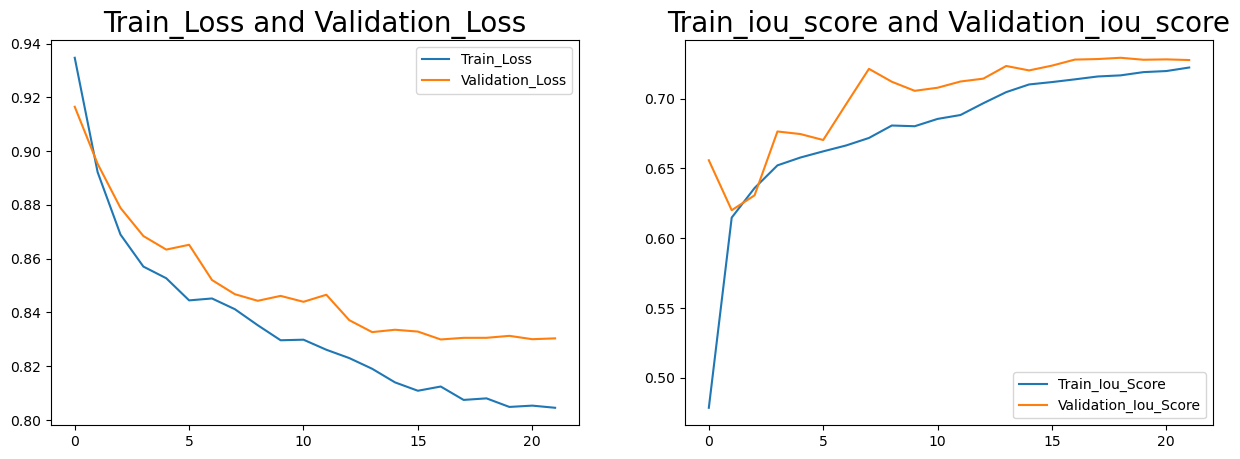

In [12]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(logs['train_loss'],label='Train_Loss')
plt.plot(logs['val_loss'],label='Validation_Loss')
plt.title('Train_Loss and Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(logs['train_iou_score'],label='Train_Iou_Score')
plt.plot(logs['val_iou_score'],label='Validation_Iou_Score')
plt.title('Train_iou_score and Validation_iou_score',fontsize=20)
plt.legend()

In [13]:
class TestDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, transforms_=None):
        self.df = dataframe
        # We'll use transforms for data augmentation and converting PIL images to torch tensors.
        self.transforms_ = transforms_
        self.pre_normalize = v2.Compose([
            v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        self.resize = [512, 512]
        self.class_size = 59
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img = cv2.cvtColor(cv2.imread(self.df.iloc[index]['img']), cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.df.iloc[index]['mask'],cv2.IMREAD_GRAYSCALE)
        mask[mask > self.class_size-1] = 0
        aug = self.transforms_(image=img, mask=mask)            
        img, mask = aug['image'], aug['mask']
        img_view = np.copy(img)
        mask_view = np.copy(mask)
        img = img/255
        img = self.pre_normalize(img)
        img = torch.tensor(img, dtype=torch.float).permute(2, 0, 1)
        target = torch.tensor(mask, dtype=torch.long)
        sample = {'x': img, 'y': target, 'img_view':img_view, 'mask_view':mask_view}
        return sample


test_dataset = TestDataset(val_df, test_transforms)

In [14]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, transforms_=None):
        self.df = dataframe
        # We'll use transforms for data augmentation and converting PIL images to torch tensors.
        self.transforms_ = transforms_
        self.pre_normalize = v2.Compose([
            v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        self.resize = [512, 512]
        self.class_size = 59
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img = cv2.cvtColor(cv2.imread(self.df.iloc[index]['img']), cv2.COLOR_BGR2RGB)
        aug = self.transforms_(image=img)            
        img= aug['image']
        img_view = np.copy(img)
        img = img/255
        img = self.pre_normalize(img)
        img = torch.tensor(img, dtype=torch.float).permute(2, 0, 1)
        sample = {'x': img, 'img_view':img_view}
        return sample


test_dataset = TestDataset(val_df, test_transforms)
my_dataset = MyDataset(my_df, test_transforms)

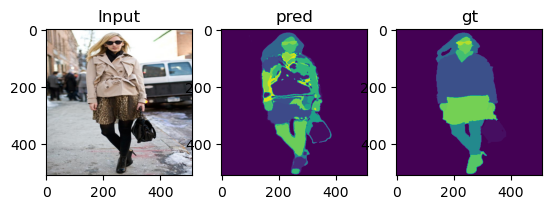

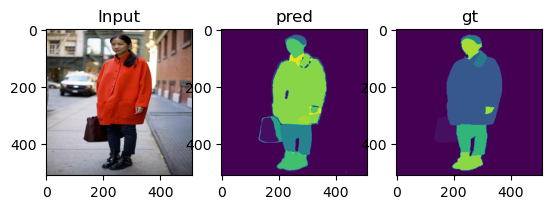

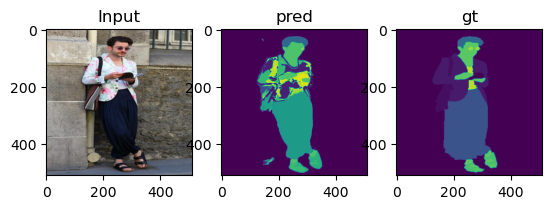

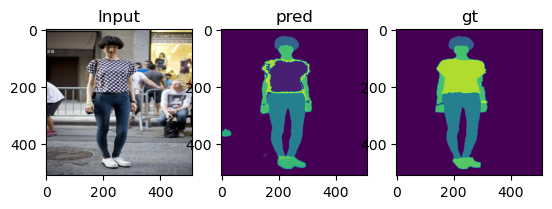

In [15]:
model.load_state_dict(torch.load("checkpoints/best.pth"))
model.to(device)
show_imgs = 4
random_list = np.random.choice(len(test_dataset), show_imgs, replace=False)

for i in range(show_imgs):
    idx = random_list[i]
    sample = test_dataset[idx]
    pred = model(sample['x'].to('cuda', dtype=torch.float32).unsqueeze(0))
    pred = torch.argmax(pred,dim=1).squeeze(0)
    pred = pred.data.cpu().numpy()
    pred_view = Image.fromarray(np.uint8(pred), 'L')

    img_view = sample['img_view']
    img_view = Image.fromarray(img_view, 'RGB')
    mask_view = sample['mask_view']
    mask_view = Image.fromarray(mask_view, 'L')
                
    f, axarr = plt.subplots(1, 3) 
    axarr[0].imshow(img_view)
    axarr[0].set_title('Input')
    axarr[1].imshow(pred_view)
    axarr[1].set_title('pred')
    axarr[2].imshow(mask_view)
    axarr[2].set_title('gt')
    plt.show()

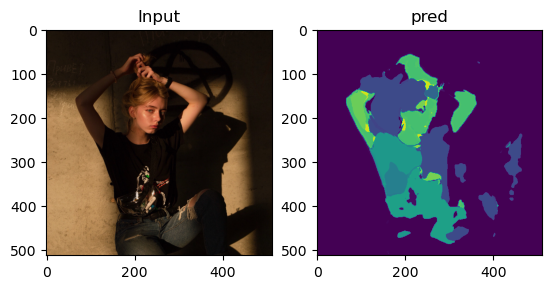

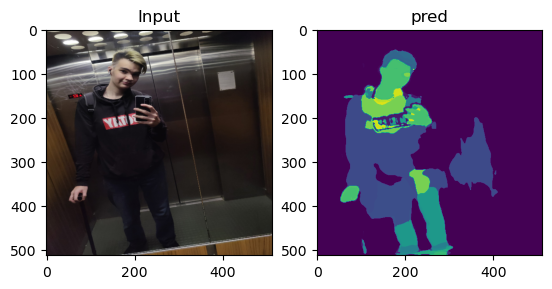

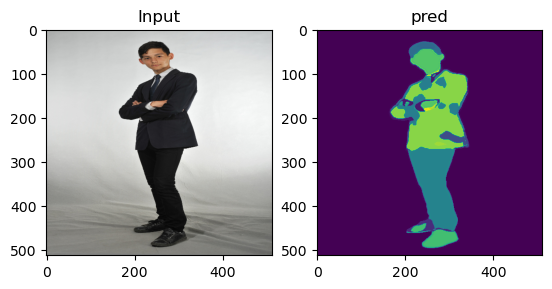

In [18]:
show_imgs = 3

for i in range(show_imgs):
    sample = my_dataset[i]
    pred = model(sample['x'].to('cuda', dtype=torch.float32).unsqueeze(0))
    pred = torch.argmax(pred,dim=1).squeeze(0)
    pred = pred.data.cpu().numpy()
    pred_view = Image.fromarray(np.uint8(pred), 'L')

    img_view = sample['img_view']
    img_view = Image.fromarray(img_view, 'RGB')
                
    f, axarr = plt.subplots(1, 2) 
    axarr[0].imshow(img_view)
    axarr[0].set_title('Input')
    axarr[1].imshow(pred_view)
    axarr[1].set_title('pred')
    plt.show()